# Data

- apartments_(train|test).csv contains information about specific apartments.
- buildings_(train|test).csv contains suplementary information about the building each apartment is located in.
- (apartments|buildings)_meta.json contains meta information about the specific columns


In [51]:
def describe_column(meta):
    """
    Utility function for describing a dataset column (see below for usage)
    """
    def f(x):
        d = pd.Series(name=x.name, dtype=object)
        m = next(m for m in meta if m['name'] == x.name)
        d['Type'] = m['type']
        d['#NaN'] = x.isna().sum()
        d['Description'] = m['desc']
        if m['type'] == 'categorical':
            counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        elif m['type'] == 'real' or m['type'] == 'integer':
            stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
            d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
        elif m['type'] == 'boolean':
            counts = x.dropna().astype(bool).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        else:
            d['Statistics'] = f'#unique={x.nunique()}'
        return d
    return f

def describe_data(data, meta):
    desc = data.apply(describe_column(meta)).T
    desc = desc.style.set_properties(**{'text-align': 'left'})
    desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
    return desc 

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import geopy.distance

# Load data

In [53]:
# Merge apartments and buildings data

apartments_train = pd.read_csv('data/apartments_train.csv')
buildings_train = pd.read_csv('data/buildings_train.csv')
apartments_test = pd.read_csv('data/apartments_test.csv')
buildings_test = pd.read_csv('data/buildings_test.csv')
data_train = pd.merge(
    apartments_train, 
    buildings_train.set_index('id'), 
    how='left', 
    left_on='building_id', 
    right_index=True
)
data_test = pd.merge(
    apartments_test, 
    buildings_test.set_index('id'), 
    how='left', 
    left_on='building_id', 
    right_index=True
)

# coordinates are based on given address
data_test.at[23, 'longitude'] = 55.57404550587989
data_test.at[23, 'latitude'] = 37.48828466189286
data_test.at[90, 'longitude'] = 55.57404550587989
data_test.at[90, 'latitude'] = 37.48828466189286

data_train.head()
data_test.head()

,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,23285,NaN,71.4,NaN,NaN,2.0,1.0,NaN,NaN,NaN,...,6к3,2017.0,2.0,20.0,1.0,1.0,1.0,NaN,1.0,0.0
1,23286,NaN,54.0,4.0,50.0,4.0,1.0,NaN,3.00,NaN,...,3к2,2017.0,2.0,15.0,0.0,1.0,1.0,0.0,0.0,0.0
2,23287,3.0,39.4,19.6,11.2,10.0,1.0,NaN,2.65,1.0,...,27,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,23288,NaN,60.9,NaN,NaN,5.0,2.0,1.0,NaN,1.0,...,23,2014.0,2.0,17.0,1.0,1.0,0.0,NaN,1.0,3.0
4,23289,NaN,34.0,9.0,17.0,14.0,1.0,NaN,2.75,1.0,...,13к1,2016.0,2.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0


## Prepare Training Data

<AxesSubplot:title={'center':'Fraction of NaN values in the training set'}>

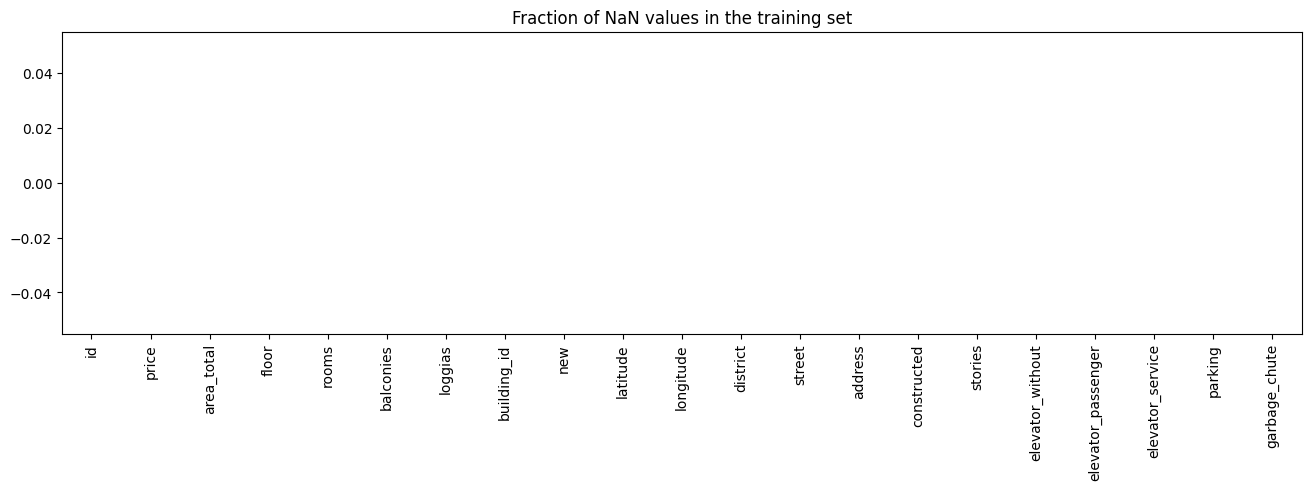

In [54]:
from sklearn.impute import KNNImputer

def prepare_data(data, test=False):
    
    imputer = KNNImputer(n_neighbors=4, weights="uniform")
    
    # remove irrelevant features
    irrelevant_features = [
        'seller',
        'layout',
        'area_kitchen',
        'area_living',
        'bathrooms_shared',
        'bathrooms_private',
        'phones',
        'condition',
        'heating',
        'material',
        'ceiling',
        'windows_court',
        'windows_street',
    ]
    data.drop(
        irrelevant_features, 
        axis=1, 
        inplace=True
    )
    
    if test:
        data['district'] = data['district'].fillna(data['district'].mode()[0])
        data['constructed'] = data['constructed'].fillna(data['constructed'].mode()[0])
    else:
        # drop rows containing NaN values for specific features
        data.drop(data[data['district'].isna()].index, inplace=True)
        data.drop(data[data['constructed'].isna()].index, inplace=True)
    
    # fill data gaps
    data['loggias'] = data['loggias'].fillna(0)
    data['balconies'] = data['balconies'].fillna(0)
    data['parking'] = data['parking'].fillna(0)
    data['garbage_chute'] = data['garbage_chute'].fillna(False)
    data['elevator_without'] = data['elevator_without'].fillna(False)
    data['elevator_passenger'] = data['elevator_passenger'].fillna(False)
    data['elevator_service'] = data['elevator_service'].fillna(False)
    data['new'] = data['new'].fillna(False)
    
    # log transformation
    data['area_total'] = (data['area_total'] + 1).transform(np.log)
    
    return data

data_train = prepare_data(data_train)

fig, ax1 = plt.subplots(figsize=(16, 4), ncols=1, dpi=100)
data_train.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')

## Feature Construction

In [55]:
def construct_features(data):
    
    # replacing longitude and latitude with distance in km
    moscow_center = [55.751244, 37.618423]
    coordinates = data[['latitude', 'longitude']].to_numpy()
    dist = [geopy.distance.distance(moscow_center, coordinate).km for coordinate in coordinates]
    data.drop(['latitude', 'longitude'], axis=1, inplace=True)
    data['distance'] = dist
    
    # computing age based on year constructed
    data['age'] = 2021 - data['constructed']
    
    return data

data_train = construct_features(data_train)
data_train.head()

,id,price,area_total,floor,rooms,balconies,loggias,building_id,new,district,...,address,constructed,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,distance,age
0,0,7139520.0,4.097672,2.0,2.0,0.0,0.0,4076,1.0,11.0,...,к2.5/2,2021.0,9.0,0.0,1.0,1.0,1.0,False,24.703331,0.0
1,1,10500000.0,4.488636,18.0,3.0,1.0,0.0,1893,0.0,2.0,...,14к3,2010.0,25.0,0.0,1.0,1.0,1.0,False,12.619097,11.0
2,2,9019650.0,4.375757,12.0,3.0,0.0,0.0,5176,1.0,6.0,...,38,2021.0,15.0,0.0,1.0,1.0,1.0,False,11.741795,0.0
3,3,10500000.0,4.488636,18.0,3.0,0.0,1.0,1893,0.0,2.0,...,14к3,2010.0,25.0,0.0,1.0,1.0,1.0,False,12.619097,11.0
4,4,13900000.0,4.369448,7.0,2.0,0.0,1.0,6604,0.0,11.0,...,1к3,2017.0,15.0,0.0,1.0,1.0,1.0,0.0,20.725554,4.0


## Handle Outliers

In [56]:
#sns.pairplot(data_train[['area_total', 'distance', 'floor', 'rooms', 'price']])

In [57]:
factor = 3
upper_lim = data_train['price'].mean () + data_train['price'].std () * factor
lower_lim = data_train['price'].mean () - data_train['price'].std () * factor

data_train = data_train[(data_train['price'] < upper_lim) & (data_train['price'] > lower_lim)]

#sns.pairplot(data_train[['area_total', 'distance', 'floor', 'rooms', 'price']])

# Data Exploration

<AxesSubplot:>

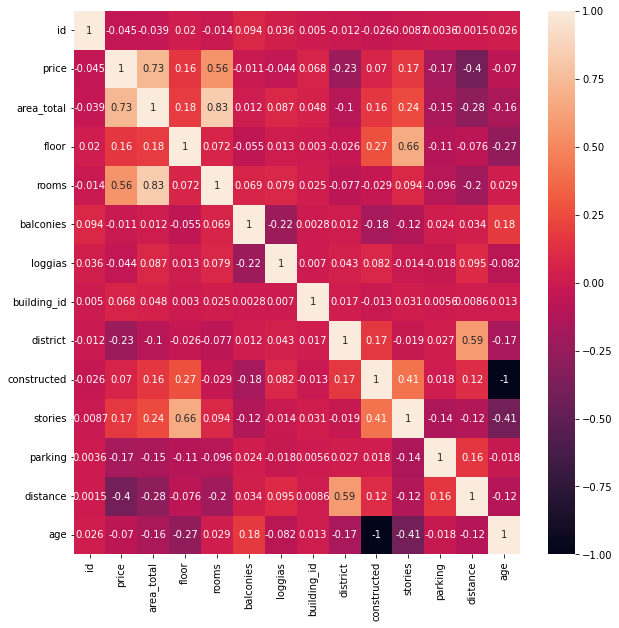

In [58]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(data_train.corr(), ax=ax, annot=True)

# Data Preparation

Text(0.5, 1.0, 'Validation set log prices')

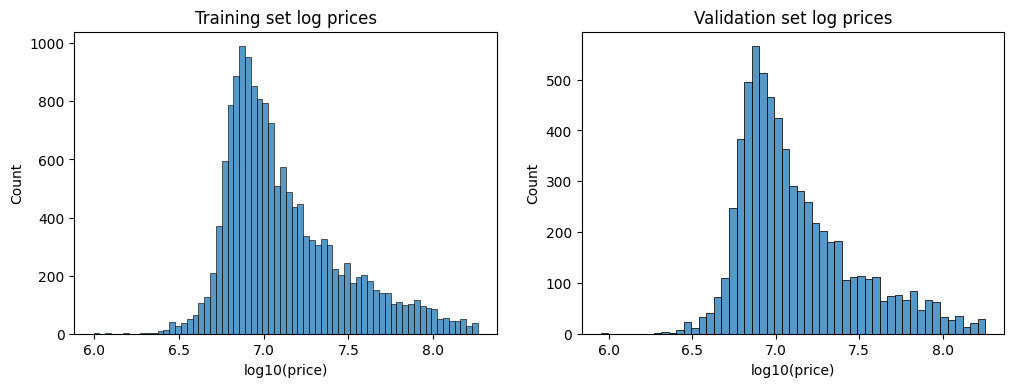

In [59]:
from sklearn.model_selection import train_test_split

relevant_features = ['distance', 'area_total', 'floor', 'stories', 'district', 'age',]
X = data_train[relevant_features]
y = data_train['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=np.log(data_train.price).round())

fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), ncols=2, dpi=100)
sns.histplot(np.log10(y_train).rename('log10(price)'), ax=ax1)
sns.histplot(np.log10(y_val).rename('log10(price)'), ax=ax2)
ax1.set_title('Training set log prices'); ax2.set_title('Validation set log prices')

# Define Loss Function and Baseline

In [60]:
from sklearn.metrics import mean_squared_log_error

def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    # assert (y_true >= 0).all() 
    # assert (y_pred >= 0).all()
    # log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    # return np.mean(log_error ** 2) ** 0.5
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

mean = y_train.mean()
y_train_hat = np.full(len(y_train), mean)
y_val_hat = np.full(len(y_val), mean)
print(f'Train rmsle: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid rmsle: {root_mean_squared_log_error(y_true=y_val, y_pred=y_val_hat) :.4f}')

Train rmsle: 0.8916
Valid rmsle: 0.8942


# Random Forest Regressor

Valid rmsle: 0.1572


Text(0, 0.5, 'Ground Truth')

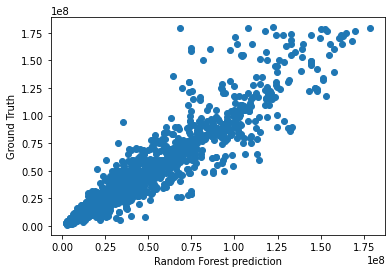

In [61]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(
    n_estimators=100, 
    criterion='mse',
    n_jobs=2,
    random_state=42,
    max_features='auto',
)
rf_reg.fit(X_train, y_train)

rf_pred = rf_reg.predict(X_val)
print(f'Valid rmsle: {root_mean_squared_log_error(y_true=y_val, y_pred=rf_pred) :.4f}')

plt.scatter(rf_pred, y_val)
plt.xlabel('Random Forest prediction')
plt.ylabel('Ground Truth')

**Gini Importance / Mean decrease in impurity (MDI)** counts the number of times a feature is used to split a node, weighted by the number of samples it splits.


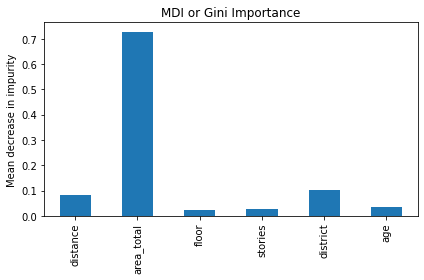

In [46]:
# Feature importance
importances = rf_reg.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("MDI or Gini Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Gradient Boosting Machine

Valid rmsle: 0.1507


Text(0, 0.5, 'Ground Truth')

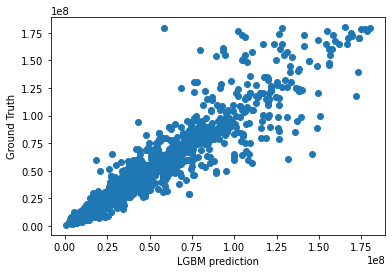

In [67]:
import lightgbm as lgbm

lgbm_reg = lgbm.LGBMRegressor(
    random_state=42, 
    silent=True, 
    metric='mse',
    n_jobs=4,
    n_estimators=2000,
    learning_rate=0.05
)

lgbm_reg.fit(X_train, y_train)

lgbm_pred = lgbm_reg.predict(X_val)
print(f'Valid rmsle: {root_mean_squared_log_error(y_true=y_val, y_pred=lgbm_pred) :.4f}')

plt.scatter(lgbm_pred, y_val)
plt.xlabel('LGBM prediction')
plt.ylabel('Ground Truth')

# Ensemble Learning

**Background:** Individual makes mistakes, but the “majority” is less likely to make mistakes.

In [ ]:
from sklearn.model_selection import KFold

# Using k-fold cross validation to improve 
# generalisation and obtain a model with less bias

n_splits = 8
random_state = 42

kf = KFold(
    n_splits=n_splits,
    shuffle=True,
    random_state=random_state
)



# Submission

In [ ]:
X_test = prepare_data(data_test, True)
X_test = construct_features(X_test)
X_test = X_test[relevant_features]
y_pred = rf_reg.predict(X_test)

submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = y_pred
submission.to_csv('submission.csv', index=False)

print('\nLine count of submission')
!wc -l submission.csv

print('\nFirst 5 rows of submission')
!head -n 5 submission.csv